In [57]:
%matplotlib inline
#%run script
import os

os.sys.path.append("..") #script path

import defs
import nibabel as nib
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt 
import SimpleITK as sitk

In [53]:
KEY_ID = 9
seg_prob_dir = "../../fine_stage/hr3d_h_e-3_16-72_d_100k__full_e-4_24-24_gdsc_1024s_dil13/output/50000_test_prob/"
seg_ref_dir = "../../data/HaN_MICCAI2015_Dataset/nii_segmentations/"

seg_prob_dir = "../../fine_stage/hr3d_h_e-3_16-72_d_100k__full_e-4_24-24_gdsc_1024s_dil13/output/50000_test_prob/orig_size"
seg_ref_dir = "../../data/HaN_MICCAI2015_Dataset/nii_segmentations_orig/"

In [133]:
def addToDict(dictionary, key, value):
    if dictionary.get(key) is None:
        dictionary[key] = [value]
    else:
        dictionary[key].append(value)
        
prob_dict = dict()
df = pd.DataFrame(columns=['file','organ','vox_cnt','mean','std', 'median','max', 'min'])

for prob_file in os.listdir(seg_prob_dir):
    for ref_file in os.listdir(seg_ref_dir):
        file_id = prob_file[:KEY_ID]
        if file_id in ref_file[:KEY_ID]:   
            
            prob_np = nib.load(os.path.join(seg_prob_dir, prob_file)).get_fdata()
            ref_file_fullpath = os.path.join(seg_ref_dir, ref_file)
            ref_np = nib.load(ref_file_fullpath).get_fdata().astype(np.uint8)
            print("evaluating: ", file_id, prob_np.shape, ref_np.shape)
            if not np.array_equal(prob_np[...,0].squeeze().shape, ref_np.shape):
                print("Warning: dimensions missmatch, resample prob map to orig resolution") 
            for key, value in defs.LABELS.items():
                prob_map = prob_np[...,value].squeeze()
                
                if not np.array_equal(prob_map.shape, ref_np.shape):
                    if ref_np.shape[2] < prob_map.shape[2]:
                        prob_map = prob_map[:ref_np.shape[0],:ref_np.shape[1],1:ref_np.shape[2]+1]
                    else:
                        prob_map_zeros = np.zeros_like(ref_np).astype(np.float64)
                        prob_map_zeros[:prob_map.shape[0],:prob_map.shape[1],1:prob_map.shape[2]+1] = prob_map
                        prob_map = prob_map_zeros

                    prob_map = prob_map[:ref_np.shape[0],:ref_np.shape[1],:ref_np.shape[2]]
                    
                label_prob = prob_map[ref_np == value]
                
                cnt, minmax, mean, std, _, _ = stats.describe(label_prob)
                median = np.median(label_prob)
                df_dict = {'file':file_id, 'organ':key, 'vox_cnt':cnt, 'mean':mean, 'std':std, 'median':median,
                          'max':minmax[1], 'min':minmax[0]}
                df = df.append(df_dict, ignore_index=True)
                
                addToDict(prob_dict, key, label_prob.flatten())

evaluating:  0522c0669 (512, 512, 137, 1, 8) (512, 512, 137)
evaluating:  0522c0555 (512, 512, 263, 1, 8) (512, 512, 263)
evaluating:  0522c0708 (512, 512, 160, 1, 8) (512, 512, 159)
evaluating:  0522c0598 (512, 512, 135, 1, 8) (512, 512, 135)
evaluating:  0522c0788 (512, 512, 131, 1, 8) (512, 512, 131)
evaluating:  0522c0659 (512, 512, 164, 1, 8) (512, 512, 165)
evaluating:  0522c0727 (512, 512, 131, 1, 8) (512, 512, 131)
evaluating:  0522c0878 (512, 512, 132, 1, 8) (512, 512, 132)
evaluating:  0522c0661 (512, 512, 151, 1, 8) (512, 512, 151)
evaluating:  0522c0667 (512, 512, 146, 1, 8) (512, 512, 146)
evaluating:  0522c0746 (512, 512, 109, 1, 8) (512, 512, 109)
evaluating:  0522c0806 (512, 512, 124, 1, 8) (512, 512, 124)
evaluating:  0522c0857 (512, 512, 151, 1, 8) (512, 512, 151)
evaluating:  0522c0845 (512, 512, 167, 1, 8) (512, 512, 167)


In [134]:
df.groupby(['organ']).mean() #orig file resolution

,mean,std,median,max,min
organ,,,,,
BrainStem,0.792444,0.133218,0.998411,1.000000,1.456169e-06
Chiasm,0.498455,0.185243,0.508738,0.928649,9.059723e-06
Mandible,0.876144,0.092492,0.999977,1.000000,1.157150e-08
OpticNerve_L,0.746050,0.150058,0.949689,1.000000,5.319554e-04
OpticNerve_R,0.729986,0.165702,0.954513,1.000000,4.655284e-05
Parotid_L,0.731875,0.148043,0.920231,1.000000,1.888331e-08
Parotid_R,0.763608,0.137666,0.948323,1.000000,5.976827e-08


In [39]:
df.groupby(['organ']).mean() #training resolution

,mean,std,median,max,min
organ,,,,,
BrainStem,0.790042,0.135007,0.998272,1.000000,1.352908e-06
Chiasm,0.462864,0.190733,0.434555,0.933167,4.341783e-06
Mandible,0.883437,0.087129,0.999980,1.000000,1.938384e-08
OpticNerve_L,0.759809,0.149179,0.957136,1.000000,1.215768e-04
OpticNerve_R,0.774518,0.147070,0.998406,1.000000,6.610369e-05
Parotid_L,0.738797,0.145434,0.923101,1.000000,1.942154e-08
Parotid_R,0.765900,0.137609,0.959697,1.000000,2.716878e-08


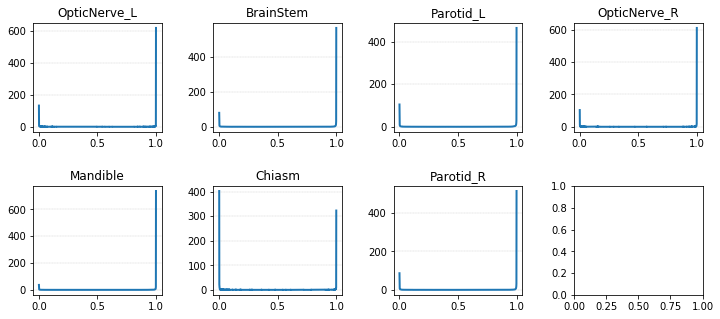

In [52]:
fig, axarr = plt.subplots(2, 4, figsize=(12,5))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
axarr = axarr.ravel()
ind = 0
for key, value in defs.LABELS.items():
    combinedlist = np.concatenate(prob_dict[key])
    y,binEdges=np.histogram(combinedlist,bins=1000,density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    #axis.hist(combinedlist, density=True, bins=500)
    axarr[ind].plot(bincenters,y,'-', label=key, linewidth=2)
    #axarr[ind].set_xlim([-5,5])
    axarr[ind].set_title(key)
    axarr[ind].grid(True, axis="y", linestyle='--', linewidth=0.3)
    
    #axarr[ind].boxplot(np.array(combinedlist))
    #axarr[ind].set_title(key)
    #axarr[ind].set_ylim(0, 65)
    ind += 1

In [130]:
sample_prob = os.path.join(seg_prob_dir, "0522c0708_niftynet_out.nii.gz")
sample_ref = os.path.join(seg_ref_dir, "0522c0708_segmentation.nii.gz")

prob_img = nib.load(sample_prob)
ref_img = nib.load(sample_ref)

prob_np = prob_img.get_fdata()
ref_np = ref_img.get_fdata().astype(np.uint8)

In [132]:
for key, value in defs.LABELS.items():
    prob_map = prob_np[...,value].squeeze()
    #print(prob_map.sum())
    #print(prob_np.shape)
    #print(ref_np.shape)
    if not np.array_equal(prob_map.shape, ref_np.shape):
        if ref_np.shape[2] < prob_map.shape[2]:
            prob_map = prob_map[:ref_np.shape[0],:ref_np.shape[1],1:ref_np.shape[2]+1]
        else:
            prob_map_zeros = np.zeros_like(ref_np).astype(np.float64)
            prob_map_zeros[:prob_map.shape[0],:prob_map.shape[1],1:prob_map.shape[2]+1] = prob_map
            prob_map = prob_map_zeros
        #ref_sitk = sitk.ReadImage(ref_file_fullpath, sitk.sitkUInt8)
        #resampler = sitk.ResampleImageFilter()
        #resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        #resampler.SetSize(ref_np.shape)
        #resampler.SetOutputPixelType(sitk.sitkUnknown)
        #prob_map_sitk = sitk.GetImageFromArray(prob_map)
        #print(prob_map_sitk.GetPixelIDTypeAsString())
        #prob_map_sitk = resampler.Execute(prob_map_sitk)

        
        #prob_map_sitk.SetOrigin(ref_sitk.GetOrigin())
        #prob_map_sitk.SetDirection(ref_sitk.GetDirection())
        #prob_map_sit.Se

        #prob_map = sitk.GetArrayFromImage(prob_map_sitk)
        #print(prob_map.sum())
        #print(prob_map_sitk.GetSize())
        #resampler.SetOutputSpacing(newSpacing)

        #print(prob_map.shape)

    label_prob = prob_map[ref_np == value]

    cnt, minmax, mean, std, _, _ = stats.describe(label_prob)
    median = np.median(label_prob)
    print(key, cnt, minmax, mean, std, median)

OpticNerve_L 119 (4.1300377233710606e-06, 1.0) 0.5944946709626171 0.2113213577478208 0.9689664244651794
BrainStem 7281 (3.280203486610844e-08, 1.0) 0.6826111691116987 0.18781778329201654 0.9946877956390381
Parotid_L 7614 (8.596064415833382e-10, 1.0) 0.8710016400075037 0.08998878802112124 0.9999139904975891
OpticNerve_R 137 (1.2284277772778296e-07, 1.0) 0.49726896503985196 0.212625554691934 0.39508554339408875
Mandible 13568 (7.633929044459364e-10, 1.0) 0.8195652231195206 0.13543502149688552 0.9999939203262329
Chiasm 139 (2.0208604212257342e-07, 1.0) 0.5710126184204043 0.23838301951009608 0.999544084072113
Parotid_R 7474 (2.718196334683398e-08, 1.0) 0.8877256873126156 0.08110310720656107 0.9999215602874756
